# Solar Position Algorithms | Validation with USNO

In the following tutorial the validation of solar position angles utilizing data from USNO is demonstrated.

<div class="grid cards" markdown>

- __1. Introduction__

    In this tutorial, the first step is to import the necessary packages.

- __2. Download USNO data__

    This tutorial includes code blocks that demonstrate how to download data from the USNO API.
  
- __3. Data preparation__

    Data handling for the retrieved USNO data is demonstrated, along with implemented PVGIS' NOAA model call for solar positioning.
  
- __4. Visualization__

   Finally, the visualization of the differences of solar altitude and solar azimuth are presented.

</div>


## Programmatic preamble

Import the required libraries:

In [1]:
import os
import random
from zoneinfo import ZoneInfo
import pandas as pd
from pandas import DatetimeIndex, Timestamp
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from pvgisprototype.api.position.overview import model_solar_position_overview_series
from pvgisprototype import Longitude
from pvgisprototype import Latitude
from pvgisprototype import SurfaceOrientation
from pvgisprototype import SurfaceTilt
from pvgisprototype.constants import DEGREES
from pvgisprototype.api.position.models import SolarPositionModel
from pvgisprototype.api.position.models import SolarIncidenceModel

## Download data from USNO API

First, generate random latitude and longitude values:

In [2]:
random.seed(22227)
latitude_list = [random.randint(-90, 90) for _ in range(500)]
longitude_list = [random.randint(-180, 180) for _ in range(500)]
timestamps_list =[DatetimeIndex([Timestamp(year=2010, month=random.randint(1, 12), day=random.randint(1, 28), hour=random.randint(6, 20), minute=0, second=0)]) for _ in range(500)]

Then get data from USNO API utilizing the following API client:

In [3]:
import requests
from requests import exceptions
from datetime import datetime
import json

HTTP_OK = 200
SERVER = "https://aa.usno.navy.mil/api/celnav"

def query_usno(longitude:float, 
               latitude:float, 
               date:datetime)->tuple:
    """Get almanac values for Sun from USNO for a specific place and datetime.
    Note that all values are returned for zone UT1. UT1 and UTC are the practically the same, but they differ by as much as 0.9 seconds.

    Args:
        latitude (float): Latitude value
        longitude (float): Longitude value
        date (datetime): Specific date and time to calculate the position

    Raises:
        exceptions.HTTPError: Raises if HTTP return code is not 200

    Returns:
        tuple: Returns solar azimuth, solar altitude, solar declination, solar hour angle in decimal degrees
    """
    parameters = {
            "date": date.date(),
            "time": date.time(),
            "coords": f"{latitude},{longitude}",
            }
    print("------------------")
    print("Getting data for:")
    print(f"{longitude=}")
    print(f"{latitude=}")
    print(f"{date=}")
    request = requests.get(SERVER, params = parameters)
    print("Done!")
    
    print("Analyzing data...")
    if request.status_code != HTTP_OK:
        raise exceptions.HTTPError(f"Failed retrieving USNO data, server returned HTTP code: {request.status_code} on following URL {request.url}.")
    
    data = json.loads(request.content.decode("utf-8"))
    try:
        solar_data = next(item for item in data['properties']['data'] if item['object'] == 'Sun')
        solar_azimuth = solar_data["almanac_data"]["zn"]
        solar_altitude = solar_data["almanac_data"]["hc"]
        solar_declination = solar_data["almanac_data"]["dec"]
        solar_hour_angle = solar_data["almanac_data"]["gha"]
    except StopIteration:
        solar_azimuth = None
        solar_altitude = None
        solar_declination = None
        solar_hour_angle = None

    print("Done!")
    print("------------------")

    return (solar_azimuth, solar_altitude, solar_declination, solar_hour_angle)

By executing the following cell data are downloaded for the random locations above:

In [4]:
datapath_usno = "./USNO_data_random.csv"
if not os.path.exists(datapath_usno):
    azimuth, altitude, declination, hour_angle = [], [], [], []
    for (latitude, longitude, timestamp) in zip(latitude_list, longitude_list, timestamps_list):
        date = timestamp[0]
        az, al, dec, ha = query_usno(longitude, latitude, date)
        azimuth.append(az)    
        altitude.append(al)
        declination.append(dec)
        hour_angle.append(ha)
    data_usno = pd.DataFrame({'Latitude': latitude_list, 
                              'Longitude': longitude_list, 
                              'Datetime': [timestamp[0].strftime("%Y-%m-%d %H:%M:%S") for timestamp in timestamps_list],
                              'Solar Azimuth': azimuth,
                              'Solar Altitude': altitude,
                              'Solar Declination': declination,
                              'Hour Angle': hour_angle,
                             })
    data_usno = data_usno.dropna()
    data_usno.to_csv(datapath_usno, index=False)
else:
    data_usno = pd.read_csv(datapath_usno)

## Data preparation

Read again the data since USNO API returns also None values and the lists have changed:

In [5]:
latitude_list = data_usno['Latitude'].tolist()
longitude_list = data_usno['Longitude'].tolist()
timestamps_list = [DatetimeIndex([pd.to_datetime(date)]) for date in data_usno['Datetime'].tolist()]

Provide the coordinates and timestamps to PVGIS6:

In [6]:
import math
azimuth, altitude, declination, hour_angle = [], [], [], []
for latitude, longitude, timestamp in zip(latitude_list, longitude_list, timestamps_list):
    
    latitude_obj = Latitude(value=latitude, unit=DEGREES)
    longitude_obj = Longitude(value=longitude, unit=DEGREES)
    surface_orientation = SurfaceOrientation(value=180, unit=DEGREES)
    surface_tilt = SurfaceTilt(value=45, unit=DEGREES)
    timezone = ZoneInfo("UTC")
    (
    dec,
    ha,
    zen,
    al,
    az,
    orientation,
    tilt,
    incidence
    ) = model_solar_position_overview_series(
        longitude=longitude_obj,
        latitude=latitude_obj,
        timestamps=timestamp,
        timezone=timezone,
        surface_orientation=surface_orientation,
        surface_tilt=surface_tilt,
        solar_position_model=SolarPositionModel.noaa,
        apply_atmospheric_refraction=False,
        solar_incidence_model=SolarIncidenceModel.iqbal,
        zero_negative_solar_incidence_angle=False,
    )
    azimuth.append(math.degrees(az.value[0]))    
    altitude.append(math.degrees(al.value[0]))
    declination.append(math.degrees(dec.value[0]))
    hour_angle.append(math.degrees(ha.value[0]))

data_noaa = pd.DataFrame({'Latitude': latitude_list, 
                              'Longitude': longitude_list, 
                              'Datetime': [timestamp[0].strftime("%Y-%m-%d %H:%M:%S") for timestamp in timestamps_list],
                              'Solar Azimuth NOAA': azimuth,
                              'Solar Altitude NOAA': altitude,
                              'Solar Declination NOAA': declination,
                              'Hour Angle NOAA': hour_angle,
                             })

Finally merge the two dataframes `data_usno` and `data_noaa` to start the visualization:

In [7]:
final_dataframe = data_usno.merge(data_noaa)

## Comparison of PVGIS' NOAA implementation with USNO reference data

### Solar altitude

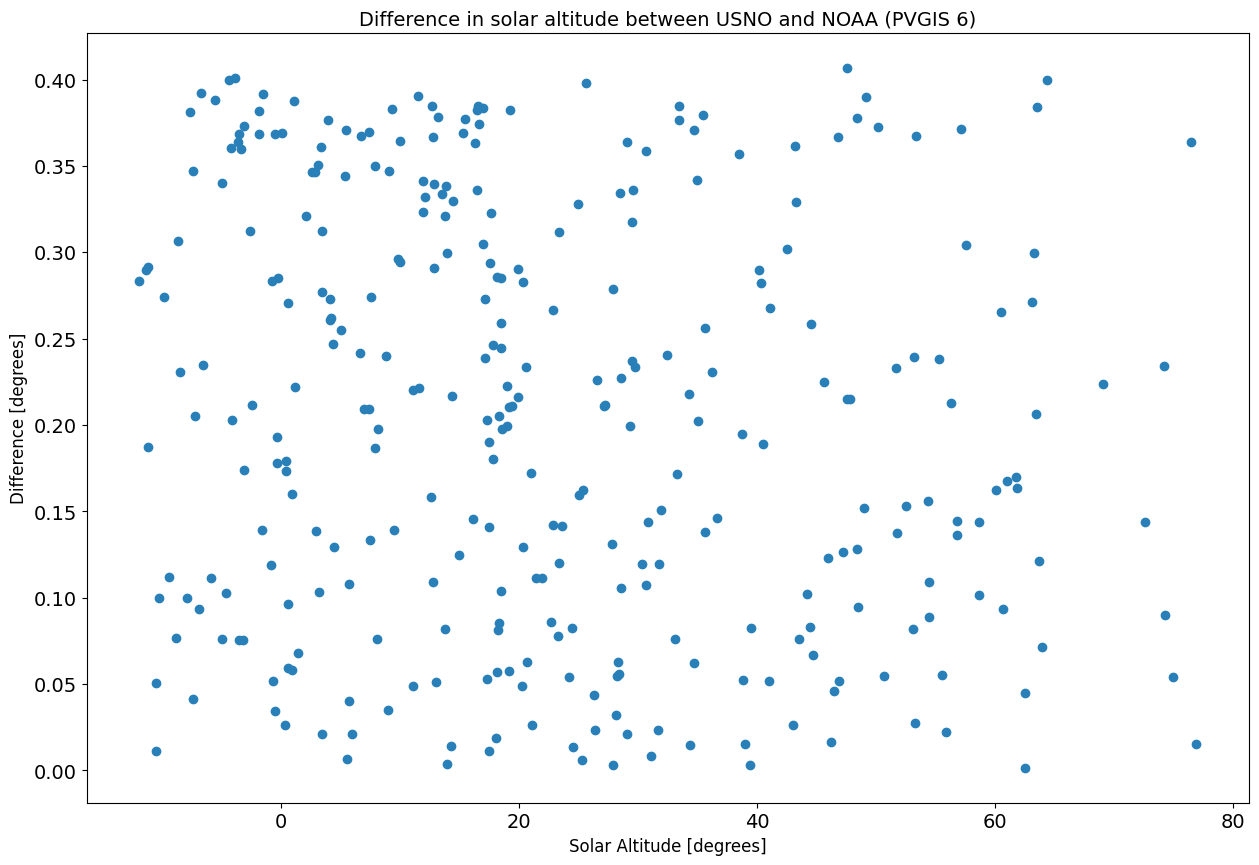

In [8]:
final_dataframe['Alt.Diff'] = abs(final_dataframe['Solar Altitude NOAA'] - final_dataframe['Solar Altitude'])
alt_error_plot = final_dataframe.plot(x='Solar Altitude NOAA', y='Alt.Diff', marker='.', linestyle='', color='#2980B9', figsize=(15,10), markersize = 12)
alt_error_plot.set_xlabel('Solar Altitude [degrees]', fontsize=12)
alt_error_plot.set_ylabel('Difference [degrees]', fontsize=12)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
alt_error_plot.set_title('Difference in solar altitude between USNO and NOAA (PVGIS 6)', fontsize=14)
alt_error_plot.get_legend().remove()

### Solar Azimuth

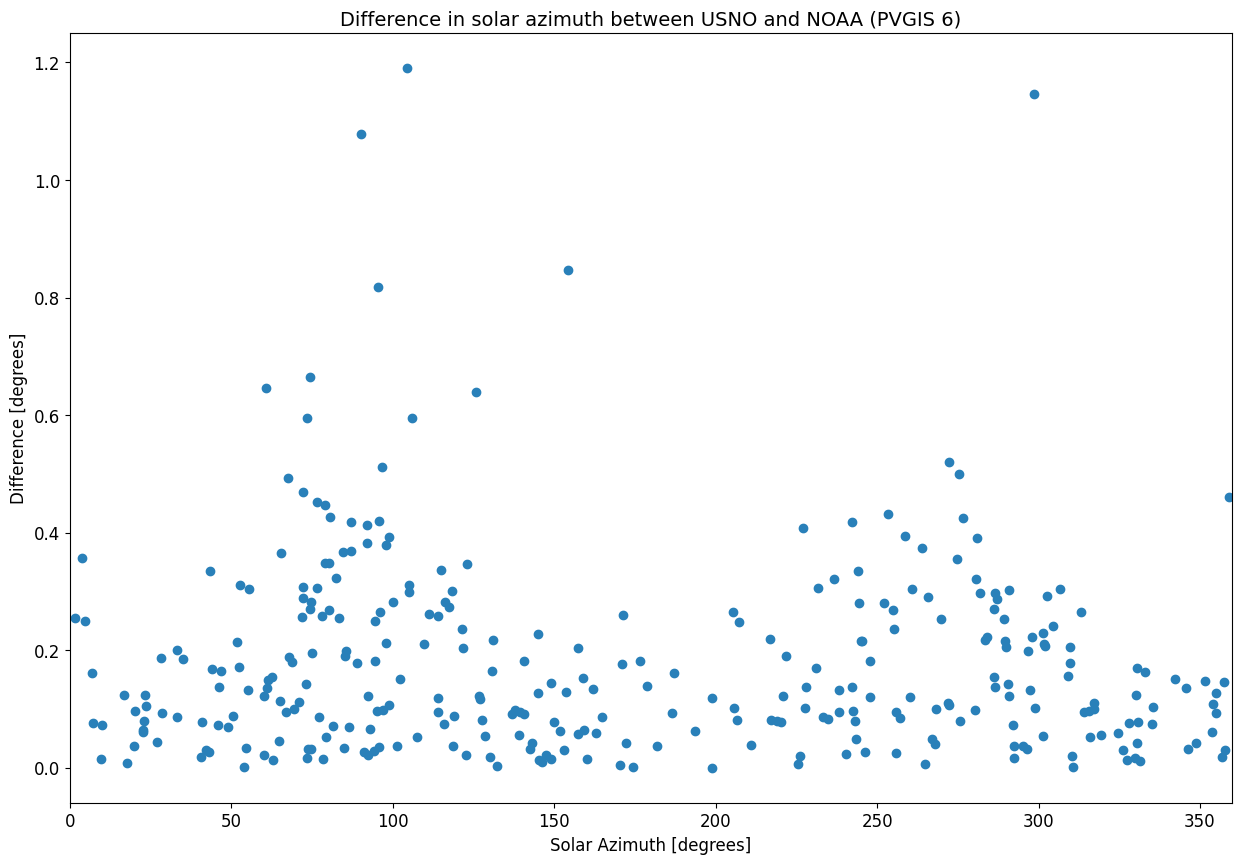

In [9]:
final_dataframe['Az.Diff'] = abs(final_dataframe['Solar Azimuth NOAA'] % 360 - final_dataframe['Solar Azimuth'] % 360)
final_dataframe['Az.Diff'] = final_dataframe['Az.Diff'].apply(lambda x: 360 - x if x > 180 else x)

az_error_plot = final_dataframe.plot(x='Solar Azimuth NOAA', y='Az.Diff', marker='.', linestyle='', color='#2980B9', figsize=(15,10), markersize = 12)
az_error_plot.set_xlabel('Solar Azimuth [degrees]', fontsize=12)
az_error_plot.set_ylabel('Difference [degrees]', fontsize=12)
az_error_plot.set_title('Difference in solar azimuth between USNO and NOAA (PVGIS 6)', fontsize=14)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
az_error_plot.set_xlim(0, 360)
az_error_plot.get_legend().remove()

### Solar azimuth as a function of longitude

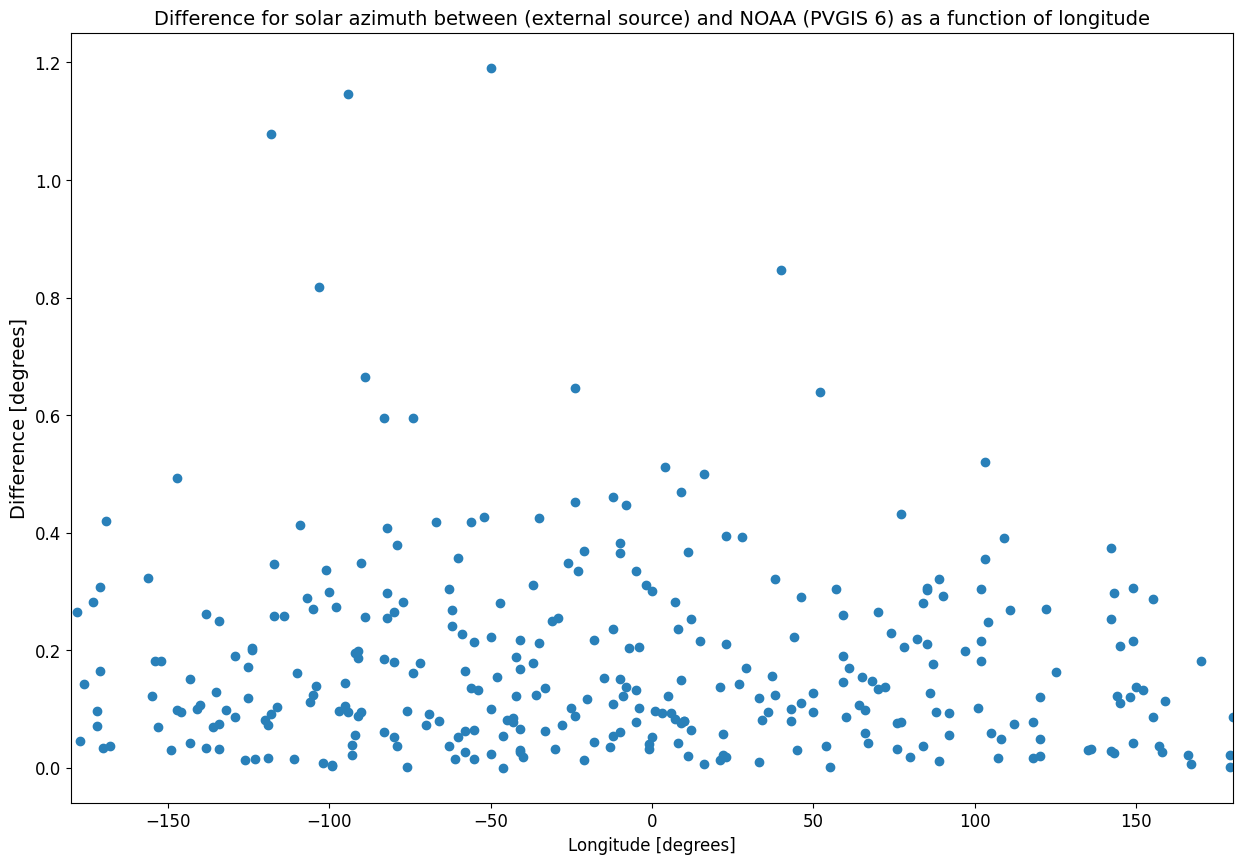

In [10]:
longitude_error_plot = final_dataframe.plot(x='Longitude', y='Az.Diff',  marker='.', linestyle='', color='#2980B9', figsize=(15,10), markersize = 12)
longitude_error_plot.set_xlabel('Longitude [degrees]', fontsize=12)
longitude_error_plot.set_xlabel('Longitude [degrees]', fontsize=12)
longitude_error_plot.set_ylabel('Difference [degrees]', fontsize=14)
longitude_error_plot.set_title('Difference for solar azimuth between (external source) and NOAA (PVGIS 6) as a function of longitude', fontsize=14)
longitude_error_plot.set_xlim(-180, 180)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
longitude_error_plot.get_legend().remove()

### Solar azimuth as a function of latitude

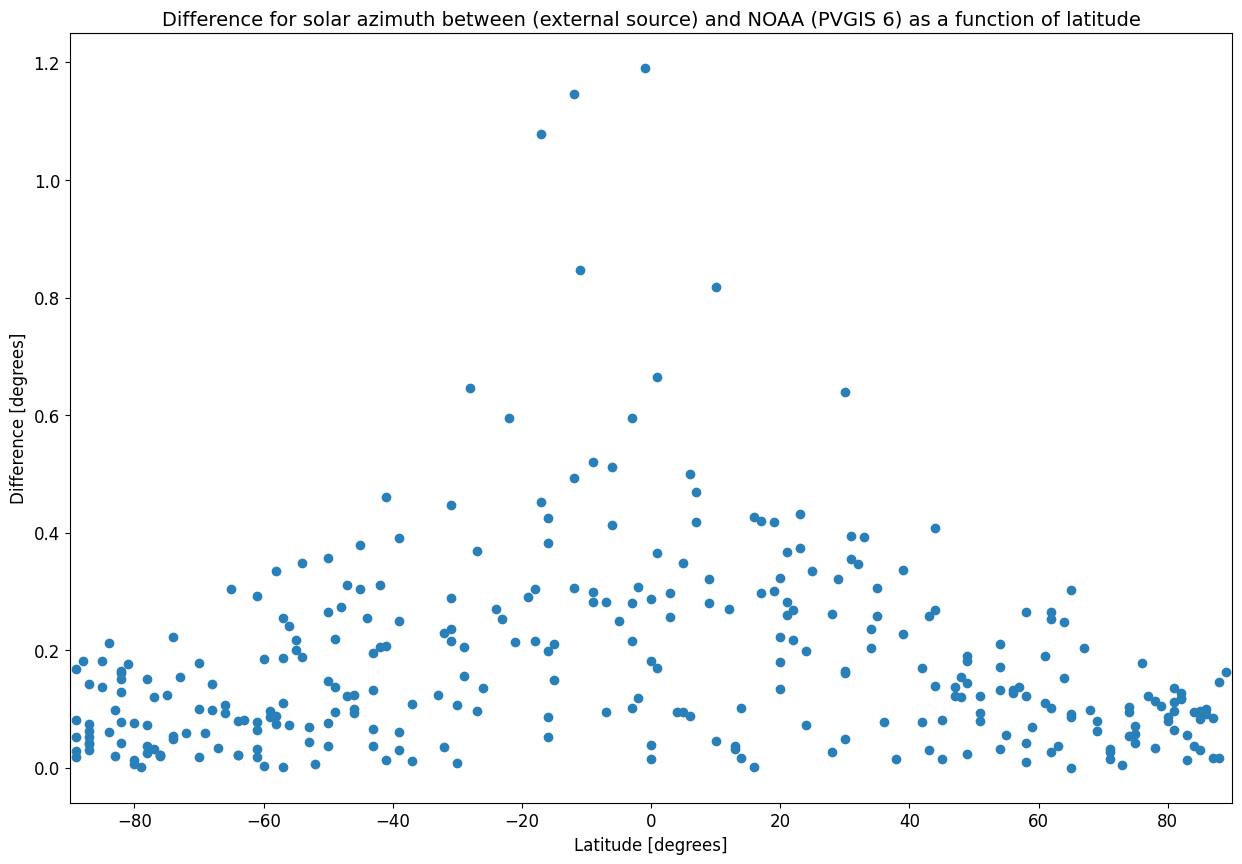

In [11]:
latitude_error_plot = final_dataframe.plot(x='Latitude', y='Az.Diff', color='#2980B9', marker='.', linestyle='', figsize=(15,10), markersize = 12)
#final_dataframe.plot(kind='scatter', x='Latitude', y='Az.Diff', color='#2980B9', ax=latitude_error_plot)
latitude_error_plot.set_xlabel('Latitude [degrees]', fontsize=12)
latitude_error_plot.set_ylabel('Difference [degrees]', fontsize=12)
latitude_error_plot.set_title('Difference for solar azimuth between (external source) and NOAA (PVGIS 6) as a function of latitude', fontsize=14)
latitude_error_plot.set_xlim(-90, 90)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
latitude_error_plot.get_legend().remove()